In [5]:
import sys
sys.path.append("..") #to access helper

import numpy as np
import powerlaw
import networkx as nx
import matplotlib.pyplot as plt

from helper import file_preprocesser, graph_analyzer

In [22]:
def find_word_regiment_candidates_grouped(deg_prob_dict, start=0, stop=0, step=1, max_diff=5):
    bucket_dict = group_by_power_of_two(deg_prob_dict)
    sorted_tuple_list = [(bucket, bucket_dict[bucket]) for bucket in sorted(bucket_dict.keys())]
    res = dict()

    for i in range(start, stop if stop != 0 else len(sorted_tuple_list), step):
        left = sorted_tuple_list[start:i]
        right = sorted_tuple_list[i:]
        probs_left = [t[1] for t in left]
        probs_right = [t[1] for t in right]
        try:
            powerlaw_left = powerlaw.Fit(probs_left, xmin = min(probs_left) )
            powerlaw_right = powerlaw.Fit(probs_right, xmin= (min(probs_right)))
            #if np.isinf(powerlaw_left.alpha) or np.isinf(powerlaw_right.alpha): continue #doenst work ,,,
            res[i] = { "left": powerlaw_left.alpha, "right": powerlaw_right.alpha}
        except Exception as e:
            print(f"Skipping {i} due to error: {e}")
            continue

    #sort by difference between left-right regmiment, desc
    res = dict(filter(lambda item: abs(item[1]["left"] - item[1]["right"]) <= max_diff, res.items()))
    res = dict(sorted(
        res.items(), 
        key=lambda item: abs(item[1]["left"] - item[1]["right"]),
        reverse=True
        ))
    return res

def group_by_power_of_two(deg_prob_dict):
    max_deg = max(deg_prob_dict.keys())
    #create neccessary buckets
    bucket_dict = dict()
    i = 0 #small world of human language starts at 2. (no 2^0=1), but this clashes with the largest power <= deg binning method.
    while 2**i < max_deg:
        bucket_dict[2**i] = 0
        i += 1
    print(str.format("Anzahl der Knotengrade: {0}, max degree: {1}, Anzahl Buckets: {2}", len(deg_prob_dict), max_deg, len(bucket_dict)))
    #fill buckets, not sure by which method papers groups so we take largest power of two <= deg
    for deg, prob in deg_prob_dict.items():
        bucket = 2 ** int(np.floor(np.log2(deg)))
        #print(str.format("deg: {0}, bin: {1}", deg, bucket))
        bucket_dict[bucket] = bucket_dict[bucket] + prob
    return bucket_dict
	
def get_deg_probability_dict(graph):
    deg_frequency_list = np.array(nx.degree_histogram(graph))
    total_nodes = graph.order()
    res = {}
    for deg in range(len(deg_frequency_list)):
        if deg_frequency_list[deg] == 0: continue
        else:
            res[deg] = deg_frequency_list[deg] / total_nodes
    return res

#Visualisierung
def grouped_deg_prob_scatter_plot(grouped_dict):
    x = np.array(list(grouped_dict.keys()), dtype=int) #degree buckets
    y = np.array(list(grouped_dict.values()),dtype=float) #prob values
    plt.scatter(x, y)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("deg")
    plt.ylabel("p(deg)")
    plt.grid(True)
    plt.show()

### Graph erzeugen

In [7]:
with open("../data/input/ALL_ALLmitMann_de.txt") as f:
    text = " ".join(f.readlines())
tokens = file_preprocesser.prepare_text_with_libraries(text, remove_stopwords=False, language="de")
G = file_preprocesser.convert_preprocessed_tokens_to_graph(tokens, neighbour_distance=1)

## Gruppierung und mögliche Trennungen

In [23]:
deg_prob_dict = get_deg_probability_dict(G)


In [25]:
regiment_candidates = find_word_regiment_candidates_grouped(deg_prob_dict, max_diff=10)
for split_at, vals in regiment_candidates.items():
    print(str.format("Trennung bei Bucket Nr.: {0} mit Wert {1} -> links: {2:.4f} / rechts: {3:.4f}", 
                     split_at, 2**split_at, vals["left"], vals["right"]))

Anzahl der Knotengrade: 712, max degree: 40226, Anzahl Buckets: 16
Skipping 0 due to error: min() iterable argument is empty
Trennung bei Bucket Nr.: 14 mit Wert 16384 -> links: 1.2082 / rechts: 2.8205
Trennung bei Bucket Nr.: 13 mit Wert 8192 -> links: 1.2520 / rechts: 2.0379
Trennung bei Bucket Nr.: 7 mit Wert 128 -> links: 1.8162 / rechts: 1.2819
Trennung bei Bucket Nr.: 6 mit Wert 64 -> links: 1.7384 / rechts: 1.2533
Trennung bei Bucket Nr.: 2 mit Wert 4 -> links: 1.6163 / rechts: 1.1869
Trennung bei Bucket Nr.: 5 mit Wert 32 -> links: 1.6519 / rechts: 1.2312
Trennung bei Bucket Nr.: 12 mit Wert 4096 -> links: 1.2829 / rechts: 1.6796
Trennung bei Bucket Nr.: 4 mit Wert 16 -> links: 1.5907 / rechts: 1.2139
Trennung bei Bucket Nr.: 3 mit Wert 8 -> links: 1.5610 / rechts: 1.1995
Trennung bei Bucket Nr.: 8 mit Wert 256 -> links: 1.6018 / rechts: 1.3195
Trennung bei Bucket Nr.: 11 mit Wert 2048 -> links: 1.2956 / rechts: 1.5183
Trennung bei Bucket Nr.: 9 mit Wert 512 -> links: 1.4501 / 

Not enough data. Returning nan
Not enough data. Returning nan


In [20]:
regiment_candidates = find_word_regiment_candidates_grouped(deg_prob_dict, start=1, max_diff=10)
for split_at, vals in regiment_candidates.items():
    print(str.format("Trennung bei Bucket Nr.: {0} mit Wert {1} -> links: {2:.4f} / rechts: {3:.4f}", 
                     split_at, 2**split_at, vals["left"], vals["right"]))

max degree: 40226, Anzahl Buckets: 16
Skipping 1 due to error: min() iterable argument is empty
Trennung bei Bucket Nr.: 14 mit Wert 16384 -> links: 1.2117 / rechts: 2.8205
Trennung bei Bucket Nr.: 3 mit Wert 8 -> links: 2.7501 / rechts: 1.1995
Trennung bei Bucket Nr.: 4 mit Wert 16 -> links: 2.1992 / rechts: 1.2139
Trennung bei Bucket Nr.: 13 mit Wert 8192 -> links: 1.2556 / rechts: 2.0379
Trennung bei Bucket Nr.: 5 mit Wert 32 -> links: 1.9814 / rechts: 1.2312
Trennung bei Bucket Nr.: 6 mit Wert 64 -> links: 1.8550 / rechts: 1.2533
Trennung bei Bucket Nr.: 7 mit Wert 128 -> links: 1.7058 / rechts: 1.2819
Trennung bei Bucket Nr.: 12 mit Wert 4096 -> links: 1.2854 / rechts: 1.6796
Trennung bei Bucket Nr.: 8 mit Wert 256 -> links: 1.5580 / rechts: 1.3195
Trennung bei Bucket Nr.: 11 mit Wert 2048 -> links: 1.2958 / rechts: 1.5183
Trennung bei Bucket Nr.: 10 mit Wert 1024 -> links: 1.3467 / rechts: 1.4322
Trennung bei Bucket Nr.: 9 mit Wert 512 -> links: 1.4345 / rechts: 1.3687


/home/sebastian/Programming/Python/venvs/komplNetzeVenv/lib/python3.12/site-packages/powerlaw.py:1151: RuntimeWarning: divide by zero encountered in scalar divide
  self.alpha = 1 + (self.n / sum(log(data/self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan


max degree: 40226, Anzahl Buckets: 16


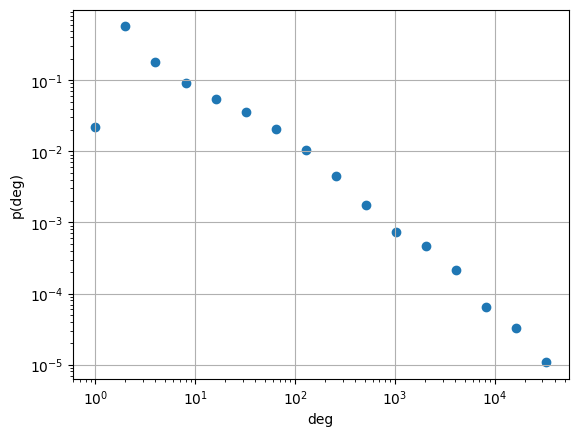

In [16]:
grouped_deg_prob_scatter_plot(group_by_power_of_two(get_deg_probability_dict(G)))